In [1]:
#The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [2]:
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


ALL_DATASET_URL = https://data.world/data-society/bank-marketing-data #Information on all the dataset

In [3]:
TRAIN_AND_TEST_DATASET = 'https://query.data.world/s/rdaf6k7gaxvd4ng6a5vjr7l5die2z4?dws=00000'
VALIDATION_DATASET = 'https://query.data.world/s/y4gb5ul3sbmwi7zfko6pin3tjglkab?dws=00000'

In [4]:
train_test_df = pd.read_csv(TRAIN_AND_TEST_DATASET, delimiter=';')
validation_df = pd.read_csv(VALIDATION_DATASET, delimiter=';')

In [5]:
#data cleaning

train_test_df.dropna(inplace=True)
validation_df.dropna(inplace=True)

In [6]:
train_test_target = train_test_df["y"].apply(lambda x: 1 if x == 'yes' else 0)  # Convert to binary
validation_target = validation_df["y"].apply(lambda x: 1 if x == 'yes' else 0)  # Convert to binary

In [8]:
train_test_features = train_test_df.drop(columns=["y"])
validation_features = validation_df.drop(columns=["y"])

In [9]:
#split train_test to train and test

train_features, test_features, train_target, test_target = train_test_split(train_test_features, train_test_target, test_size = 0.33, random_state=42)

In [10]:
ss = StandardScaler()

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_and_encode(df):
    if isinstance(df, pd.Series):  # Handle series
        df = df.to_frame()

    # Create copies of the DataFrame to avoid modifying the original data directly
    df_encoded = pd.DataFrame(index=df.index)  # both new dataframes should use the same index in order to preserve alignment
    df_standardized = pd.DataFrame(index=df.index)
    ss = StandardScaler()

    cols_to_encode = []
    cols_to_standardize = []

    for col in df.columns:
        if df[col].dtype == 'O':  # if the column contains categorical values, then encode
            cols_to_encode.append(col)
        elif df[col].dtype == 'int64' or df[col].dtype == 'float64':  # if column is numerical then standardize
            cols_to_standardize.append(col)
        else:
            raise Exception(f"Unaccounted for column type: {col}, dtype: {df[col].dtype}")

    # Standardize numerical columns
    if cols_to_standardize:
        df_standardized[cols_to_standardize] = ss.fit_transform(df[cols_to_standardize])

    # Encode categorical columns
    if cols_to_encode:
        df_encoded = pd.get_dummies(df[cols_to_encode], dtype=int)

    # Concatenate the standardized and encoded columns
    final_df = pd.concat([df_standardized, df_encoded], axis=1)

    # Ensure all columns are numeric
    final_df = final_df.apply(pd.to_numeric, errors='raise')

    if df.shape[0] != final_df.shape[0]:  # final df and original df must have the same number of rows
        raise Exception("Unaccounted new rows were created in the final dataframe")

    # Check for any null values in the final DataFrame
    if final_df.isnull().values.any():
        raise Exception("A row contains an unaccounted for null value")

    return final_df

def standardize_and_encode_df(df, target=None):
    """
    Standardize numerical columns and encode categorical columns in the given DataFrame.
    If a target Series is provided, it will be processed separately.
    """
    processed_df = standardize_and_encode(df)
    processed_target = None

    if target is not None:
        if isinstance(target, pd.Series):
            # Encode the target column with yes as 1 and no as 0
            if target.dtype == 'O':
                processed_target = target.map({'true': 1, 'false': 0, 'no': 0, 'yes': 1}) # didn't use pd.get_dummies here because my target series should only have one column, so that model loss can be easily calculated
                processed_target = standardize_and_encode(processed_target)
            else:
                processed_target = target
        else:
            raise Exception("Target must be a pandas Series")

    if processed_target is not None:
        return processed_df, processed_target
    return processed_df


In [12]:
final_train_features = standardize_and_encode_df(train_features)
final_test_features = standardize_and_encode_df(test_features)
final_validation_features = standardize_and_encode_df(validation_features)

In [13]:
def to_tensor(df, target=None, device='cpu'):
    """
    Convert DataFrame and Series to PyTorch tensors with appropriate data types.
    """
    features_tensor = torch.tensor(df.values, dtype=torch.float32, device=device)
    target_tensor = None

    if target is not None:
      target_tensor = torch.tensor(target.values, dtype=torch.float32, device=device)

    return features_tensor, target_tensor

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
train_features_tensor, train_target_tensor = to_tensor(final_train_features, train_target, device=device)
test_features_tensor, test_target_tensor = to_tensor(final_test_features, test_target, device=device)
validation_features_tensor, validation_target_tensor = to_tensor(final_validation_features, validation_target, device=device)

In [16]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_features_tensor, train_target_tensor)
test_dataset = TensorDataset(test_features_tensor, test_target_tensor)
validation_dataset = TensorDataset(validation_features_tensor, validation_target_tensor)


In [17]:
batch_size = 64
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [18]:
class SubscribeToTermDepositV2(torch.nn.Module):

  def __init__(self, in_features, out_features = 1):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(in_features= in_features, out_features = 128),
        torch.nn.BatchNorm1d(num_features = 128),
        torch.nn.ReLU(),

        torch.nn.Linear(in_features= 128, out_features = 186),
        torch.nn.BatchNorm1d(num_features = 186),
        torch.nn.ReLU(),

        torch.nn.Dropout(0.5),

        torch.nn.Linear(in_features= 186, out_features = 128),
        torch.nn.BatchNorm1d(num_features = 128),
        torch.nn.ReLU(),

        torch.nn.Linear(in_features= 128, out_features = 64),
        torch.nn.BatchNorm1d(num_features = 64),
        torch.nn.ReLU(),

        torch.nn.Linear(in_features= 64, out_features = 1),
    )


  def forward(self, X):
    return self.layers(X).squeeze(dim=1)


In [19]:
model = SubscribeToTermDepositV2(in_features=63)
model.to(device)

SubscribeToTermDepositV2(
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=186, bias=True)
    (4): BatchNorm1d(186, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=186, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [20]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

loss_fn = BCEWithLogitsLoss()
optimizer = Adam(params=model.parameters(), lr= 0.005, weight_decay=1e-4)

In [21]:
history = {
    'train': {
        'loss': [],
        'accuracy': [],
    },
    'validation': {
        'loss': [],
        'accuracy': [],
    }
}

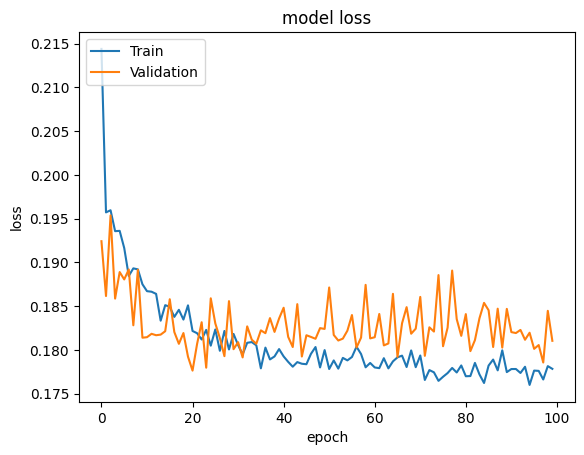

In [22]:
num_epochs = 100

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_data_loader)
    history['train']['loss'].append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(test_data_loader)
    history['validation']['loss'].append(avg_val_loss)

# summarize history for loss
plt.plot(history['train']['loss'])
plt.plot(history['validation']['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Test Loss: 0.1814
Test Accuracy: 0.9152


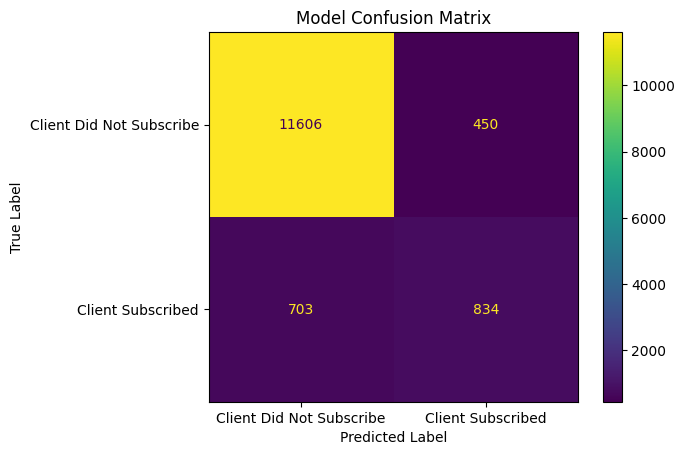

In [23]:
# Testing phase
model.eval()
running_test_loss = 0.0
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        labels_np = labels.cpu().numpy()
        outputs_np = torch.sigmoid(outputs).cpu().numpy()
        preds_np = (outputs_np >= 0.5).astype(int)

        all_labels.extend(labels_np)
        all_preds.extend(preds_np)

        running_test_loss += loss.item()

#calculate accuracy

avg_test_loss = running_test_loss / len(test_data_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix with labels
display_labels = ['Client Did Not Subscribe', 'Client Subscribed']  # Adjust according to your classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()

disp.ax_.set_title('Model Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')
disp.ax_.set_ylabel('True Label')

# Show plot
plt.show()

In [24]:
torch.save(model.state_dict(), 'model_state_dict.pth')